In [1]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM
import warnings
warnings.filterwarnings("ignore")

2023-04-11 22:31:03.414798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 22:31:04.378222: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /DATA/kumar156/.local/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:
2023-04-11 22:31:04.378366: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /DATA/kumar156/.local/lib/python3.7/site-

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
config = dict(
    saved_path="saved_models/efficientb4_cifar10.pt",
    best_saved_path = "saved/random_best.pt",
    lr=0.001, 
    EPOCHS = 3,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 132,
    TRAIN_VALID_SPLIT = 0.2,
    device=device,
    SEED = 42,
    pin_memory=True,
    num_workers=2,
    USE_AMP = True,
    channels_last=False)

In [5]:
random.seed(config['SEED'])
# If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG 
np.random.seed(config['SEED'])
# Prevent RNG for CPU and GPU using torch
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
path1 = '../../dataset/CrisisMMD_v2.0/CrisisMMD_v2.0/'
classes = os.listdir('../../dataset/CrisisMMD_v2.0/CrisisMMD_v2.0/data_image/')
classes

['iraq_iran_earthquake',
 'srilanka_floods',
 'mexico_earthquake',
 'hurricane_harvey',
 'california_wildfires']

In [8]:
path = '../../dataset/CrisisMMD_v2.0/CrisisMMD_v2.0/crisismmd_datasplit_all/'
os.listdir(path)

['Readme.txt',
 'task_damage_text_img_dev.tsv',
 'task_humanitarian_text_img_train.tsv',
 'task_damage_text_img_test.tsv',
 'task_informative_text_img_test.tsv',
 'task_informative_text_img_train.tsv',
 'task_humanitarian_text_img_test.tsv',
 'task_damage_text_img_train.tsv',
 'task_informative_text_img_dev.tsv',
 '.ipynb_checkpoints',
 'task_humanitarian_text_img_dev.tsv']

In [9]:
df = pd.read_csv(path+'task_humanitarian_text_img_train.tsv',sep = '\t')
df_test = pd.read_csv(path+'task_humanitarian_text_img_test.tsv',sep = '\t')
print(df_test.shape)
print(df.shape)
df.head()

(2237, 9)
(13608, 9)


event_name            tweet_id              image_id  \
0  california_wildfires  917791291823591425  917791291823591425_1   
1  california_wildfires  917791291823591425  917791291823591425_0   
2  california_wildfires  917793137925459968  917793137925459968_0   
3  california_wildfires  917793137925459968  917793137925459968_1   
4  california_wildfires  917793137925459968  917793137925459968_2   

                                          tweet_text  \
0  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
1  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
2  RT @KAKEnews: California wildfires destroy mor...   
3  RT @KAKEnews: California wildfires destroy mor...   
4  RT @KAKEnews: California wildfires destroy mor...   

                                               image  \
0  data_image/california_wildfires/10_10_2017/917...   
1  data_image/california_wildfires/10_10_2017/917...   
2  data_image/california_wildfires/10_10_2017/917...   
3  data_image/california_wildfires/10_10_2017/917...   
4  data_image/california_wildfires/10_10_2017/917...   

                               label                         label_text  \
0                   not_humanitarian         other_relevant_information   
1         other_relevant_information         other_relevant_information   
2  infrastructure_and_utility_damage  infrastructure_and_utility_damage   
3  infrastructure_and_utility_damage  infrastructure_and_utility_damage   
4  infrastructure_and_utility_damage  infrastructure_and_utility_damage   

                         label_image label_text_image  
0                   not_humanitarian         Negative  
1  infrastructure_and_utility_damage         Negative  
2  infrastructure_and_utility_damage         Positive  
3  infrastructure_and_utility_damage         Positive  
4  infrastructure_and_utility_damage         Positive

In [10]:
# Filtering out required 5 classes
for i in range(len(df)-1,-1,-1):
    d = 1
    for j in classes:
        if j in df['image'][i]:
            d = 0
            continue
    if d: df.drop(i, inplace = True)
    
    if i<len(df_test):
        d = 1
        for j in classes:
            if j in df_test['image'][i]:
                d = 0
                continue
        if d: df_test.drop(i, inplace = True)
print(df.shape)
print(df_test.shape)

(6765, 9)
(1160, 9)


In [11]:
from transformers import BertTokenizer, VisualBertModel
# Initialize the VilBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_text(text):
    # Tokenize the text and add special tokens
    tokenized_text = tokenizer.encode_plus(text, add_special_tokens=True, max_length=128, truncation=True)
    return tokenized_text
tokenized = df['tweet_text'].apply(tokenize_text)
tokenized_test = df_test['tweet_text'].apply(tokenize_text)

def f(x):
    x = x['input_ids']
    l = len(x)
    if l==45:
        return x
    if l>45:
        return x[-45:]
    if l<45:
        return [0]*(45-l)+x

df['tweet_text'] = tokenized.apply(f)
df_test['tweet_text'] = tokenized_test.apply(f)
df.head()

event_name            tweet_id              image_id  \
0  california_wildfires  917791291823591425  917791291823591425_1   
1  california_wildfires  917791291823591425  917791291823591425_0   
2  california_wildfires  917793137925459968  917793137925459968_0   
3  california_wildfires  917793137925459968  917793137925459968_1   
4  california_wildfires  917793137925459968  917793137925459968_2   

                                          tweet_text  \
0  [2050, 30102, 30108, 2890, 11847, 3748, 10273,...   
1  [2050, 30102, 30108, 2890, 11847, 3748, 10273,...   
2  [1024, 2662, 3748, 26332, 6033, 2062, 2084, 27...   
3  [1024, 2662, 3748, 26332, 6033, 2062, 2084, 27...   
4  [1024, 2662, 3748, 26332, 6033, 2062, 2084, 27...   

                                               image  \
0  data_image/california_wildfires/10_10_2017/917...   
1  data_image/california_wildfires/10_10_2017/917...   
2  data_image/california_wildfires/10_10_2017/917...   
3  data_image/california_wildfires/10_10_2017/917...   
4  data_image/california_wildfires/10_10_2017/917...   

                               label                         label_text  \
0                   not_humanitarian         other_relevant_information   
1         other_relevant_information         other_relevant_information   
2  infrastructure_and_utility_damage  infrastructure_and_utility_damage   
3  infrastructure_and_utility_damage  infrastructure_and_utility_damage   
4  infrastructure_and_utility_damage  infrastructure_and_utility_damage   

                         label_image label_text_image  
0                   not_humanitarian         Negative  
1  infrastructure_and_utility_damage         Negative  
2  infrastructure_and_utility_damage         Positive  
3  infrastructure_and_utility_damage         Positive  
4  infrastructure_and_utility_damage         Positive

In [12]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(df['event_name'])
df['event_name'] = enc.transform(df['event_name'])
df_test['event_name'] = enc.transform(df_test['event_name'])

print(max(df['event_name']))
df.head()

4


event_name            tweet_id              image_id  \
0           0  917791291823591425  917791291823591425_1   
1           0  917791291823591425  917791291823591425_0   
2           0  917793137925459968  917793137925459968_0   
3           0  917793137925459968  917793137925459968_1   
4           0  917793137925459968  917793137925459968_2   

                                          tweet_text  \
0  [2050, 30102, 30108, 2890, 11847, 3748, 10273,...   
1  [2050, 30102, 30108, 2890, 11847, 3748, 10273,...   
2  [1024, 2662, 3748, 26332, 6033, 2062, 2084, 27...   
3  [1024, 2662, 3748, 26332, 6033, 2062, 2084, 27...   
4  [1024, 2662, 3748, 26332, 6033, 2062, 2084, 27...   

                                               image  \
0  data_image/california_wildfires/10_10_2017/917...   
1  data_image/california_wildfires/10_10_2017/917...   
2  data_image/california_wildfires/10_10_2017/917...   
3  data_image/california_wildfires/10_10_2017/917...   
4  data_image/california_wildfires/10_10_2017/917...   

                               label                         label_text  \
0                   not_humanitarian         other_relevant_information   
1         other_relevant_information         other_relevant_information   
2  infrastructure_and_utility_damage  infrastructure_and_utility_damage   
3  infrastructure_and_utility_damage  infrastructure_and_utility_damage   
4  infrastructure_and_utility_damage  infrastructure_and_utility_damage   

                         label_image label_text_image  
0                   not_humanitarian         Negative  
1  infrastructure_and_utility_damage         Negative  
2  infrastructure_and_utility_damage         Positive  
3  infrastructure_and_utility_damage         Positive  
4  infrastructure_and_utility_damage         Positive

In [13]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        #print(idx)
        # Load image from path and convert to tensor
        img_path = path1+self.df.iloc[idx]['image']
        img = Image.open(img_path).convert('RGB')
        img_tensor = data_transforms['test'](img)
        
        # Load text and convert to tensor
        text = self.df.iloc[idx]['tweet_text']
        text_tensor = torch.tensor(text)
        
        # Load labels and convert to tensor
        img_label = self.df.iloc[idx]['event_name']
        label_tensor = torch.tensor(img_label)
        
        return img_tensor, text_tensor, label_tensor
    
train_data = CustomDataset(df)
test_data = CustomDataset(df_test)
valid_data = test_data

print(len(train_data), len(valid_data))
train_dl = torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
valid_dl = torch.utils.data.DataLoader(valid_data, batch_size=1,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])

6765 1160


In [14]:
a = iter(valid_dl)
b = next(a)
print(b[0].shape, b[1].shape)
print(b[2])

torch.Size([1, 3, 132, 132]) torch.Size([1, 45])
tensor([1])


# GradCAM++

In [15]:
from torchvision.models import efficientnet_b0
from transformers import BertModel

class ViLBERT(nn.Module):
    def __init__(self, num_classes, hidden_size, dropout, pretrained = True):
        super(ViLBERT, self).__init__()
        
        # Image model
        efficientnet = efficientnet_b0(pretrained=True)
        efficientnet.classifier[1] = nn.Linear(in_features = 1280, out_features = num_classes, bias = True)
        self.img_model = efficientnet
        
        # Text model
        self.text_model = BertModel.from_pretrained('bert-base-uncased')
        self.text_classifier = nn.Sequential(
            nn.Linear(768, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )
        
        # Combined output model
        self.combined_classifier = nn.Sequential(
            nn.Linear(num_classes*2, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, 5)
        )
        
    def forward(self, img_inputs, text_inputs):
        # Image model forward pass
        img_outputs = self.img_model(img_inputs)
        
        # Text model forward pass
        text_outputs = self.text_model(text_inputs)[0][:, 0, :]
        text_outputs = self.text_classifier(text_outputs)
        
        # Combined output forward pass
        combined_outputs = torch.cat((img_outputs, text_outputs), dim=1)
        combined_outputs = self.combined_classifier(combined_outputs)
        
        return combined_outputs

In [16]:
model = ViLBERT(num_classes=5, hidden_size=256, dropout=0.2, pretrained = True)
#model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(torch.load('saved_models/finetuned.pt'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

torch.Size([1, 3, 132, 132]) torch.Size([1, 45]) torch.Size([1])


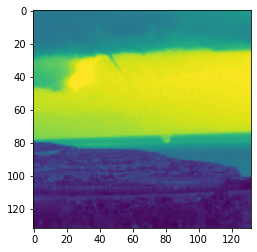

In [17]:
img, text, labels = next(iter(test_dl))
print(img.shape, text.shape, labels.shape)
plt.imshow(img[0,0,:,:])
plt.show()

In [18]:
# Define the GradCAM++ function
class GradCAMPP:
    def __init__(self, model):
        self.model = model.eval()
        self.feature_maps = None
        self.gradient_maps = None
        self.target_layer = None
        self.hooks = []

    def _find_target_layer(self):
        def hook(module, input, output):
            self.feature_maps = output.detach()

        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d):
                self.hooks.append(module.register_forward_hook(hook))
                self.target_layer = name

    def _compute_gradients(self, target_class):
        def hook(module, grad_input, grad_output):
            self.gradient_maps = grad_output[0].detach()

        target = torch.tensor([target_class])
        output = self.model(self.input_image)
        output[:, target].backward()

        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d) and name == self.target_layer:
                self.hooks.append(module.register_backward_hook(hook))

    def _normalize(self, gradient):
        epsilon = 1e-6 / (torch.mean(torch.abs(gradient)) + 1e-6)
        return gradient * epsilon

    def generate_heatmap(self, image, target_class):
        self.input_image = image.requires_grad_(True)
        self._find_target_layer()
        self._compute_gradients(target_class)

        weights = torch.mean(self.gradient_maps, axis=(2, 3), keepdims=True)
        activations = self.feature_maps
        weighted_activations = weights * activations
        heatmap = torch.mean(weighted_activations, axis=1).squeeze()
        heatmap = np.maximum(heatmap, 0)

        heatmap /= torch.max(heatmap)
        heatmap = heatmap.numpy()

        return cv2.resize(heatmap, (image.shape[3], image.shape[2]))


In [24]:
model.to('cpu')
gradcampp = GradCAMPP(model.img_model)

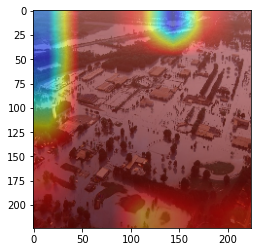

In [51]:
# Load a sample image
image = cv2.imread("crisis.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image1 = image
image = np.transpose(image, (2, 0, 1))
image = np.expand_dims(image, axis=0)
image = torch.from_numpy(image).float()

heatmap = gradcampp.generate_heatmap(image, target_class=2)
# Overlay the heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor(image1, cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

# Display the result
plt.imshow(output_image)
plt.show()

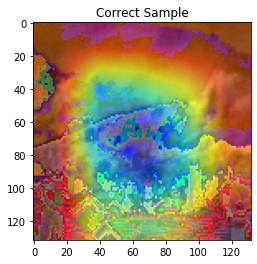

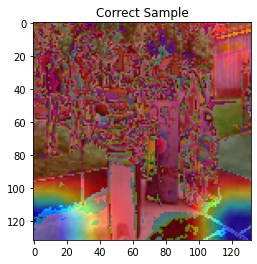

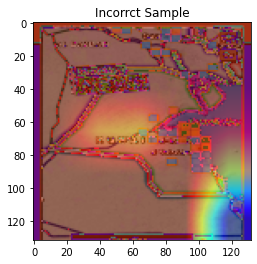

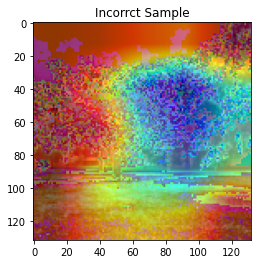

In [27]:
correct, wrong = 0,0

for i in range(50):
    img, text, label = next(iter(test_dl))
    pred = model(img, text).argmax(1)
    if pred[0] == label[0]:
        correct+=1
        if correct>2: continue
    else:
        wrong+=1
        if wrong>2: continue

    heatmap = gradcampp.generate_heatmap(img, target_class=2)
    # Overlay the heatmap on the original image
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    #img = img.detach()
    output_image = cv2.addWeighted(cv2.cvtColor((img.squeeze().detach().numpy() * 255).astype(np.uint8).transpose(1, 2, 0), cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

    # Display the result
    plt.imshow(output_image)
    if pred==label:
        plt.title('Correct Sample')
    else:
        plt.title('Incorrct Sample')
    plt.show()

In [28]:
# GradCAM with model in part D
class LSTM_CNN(nn.Module):
    def __init__(self, num_classes, hidden_size, dropout, pretrained = True):
        super(LSTM_CNN, self).__init__()
        
        # Image model
        squeezenet = torchvision.models.squeezenet1_0(pretrained=True)
        squeezenet.classifier[1] = nn.Conv2d(512, 5, kernel_size=(1, 1), stride=(1, 1))
        self.img_model = squeezenet
        
        # Text model
        self.text_model = BertModel.from_pretrained('bert-base-uncased')
        self.text_classifier = nn.Sequential(
            nn.Linear(768, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )
        
        # Combined output model
        self.combined_classifier = nn.Sequential(
            nn.Linear(num_classes*2, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, 5)
        )
        
    def forward(self, img_inputs, text_inputs):
        # Image model forward pass
        img_outputs = self.img_model(img_inputs)
        
        # Text model forward pass
        text_outputs = self.text_model(text_inputs)[0][:, 0, :]
        text_outputs = self.text_classifier(text_outputs)
        
        # Combined output forward pass
        combined_outputs = torch.cat((img_outputs, text_outputs), dim=1)
        combined_outputs = self.combined_classifier(combined_outputs)
        
        return combined_outputs
    
model = LSTM_CNN(num_classes=5, hidden_size=256, dropout=0.2, pretrained = True)
#model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(torch.load('saved_models/cnn_lstm.pt'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

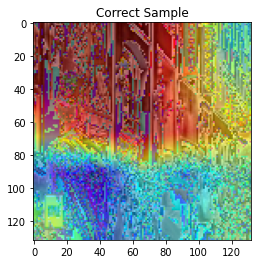

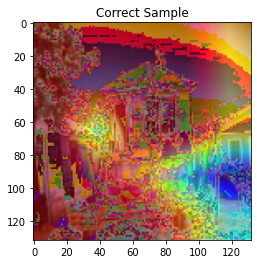

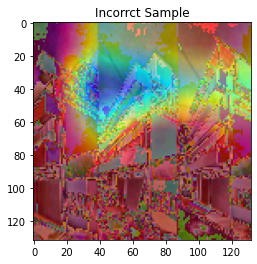

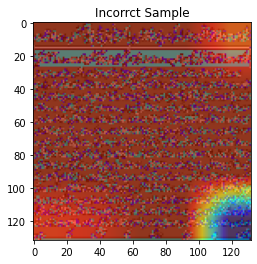

In [52]:
correct, wrong = 0,0

for i in range(20):
    img, text, label = next(iter(test_dl))
    pred = model(img, text).argmax(1)
    if pred[0] == label[0]:
        correct+=1
        if correct>2: continue
    else:
        wrong+=1
        if wrong>2: continue

    heatmap = gradcampp.generate_heatmap(img, target_class=2)
    # Overlay the heatmap on the original image
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    #img = img.detach()
    output_image = cv2.addWeighted(cv2.cvtColor((img.squeeze().detach().numpy() * 255).astype(np.uint8).transpose(1, 2, 0), cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

    # Display the result
    plt.imshow(output_image)
    if pred==label:
        plt.title('Correct Sample')
    else:
        plt.title('Incorrct Sample')
    plt.show()

# LIME (Local Interpretable Model-agnostic Explanations)

torch.Size([1, 3, 132, 132]) torch.Size([1, 45]) torch.Size([1])


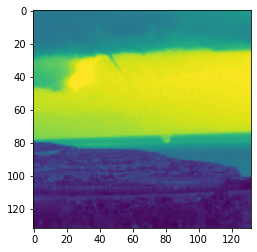

In [18]:
img, text, labels = next(iter(test_dl))
print(img.shape, text.shape, labels.shape)
plt.imshow(img[0,0,:,:])
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

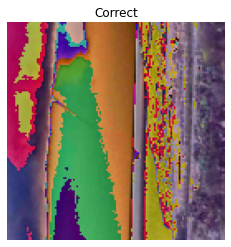

In [72]:
from lime import lime_image
# Define a function to visualize the Lime explanation for a given image

# Define a function to preprocess the input image
def preprocess_image(image):
    image = image[0,:,:,:]
    # Resize the image to 132x132
    image = cv2.resize(image, (132, 132))
    # Convert the image to a PyTorch tensor
    tensor = torch.Tensor(np.transpose(image, (2, 0, 1)))
    # Create a transform to normalize the tensor using the ImageNet mean and standard deviation
    transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Apply the transform to the tensor
    tensor = transform(tensor)
    # Add a batch dimension to the tensor
    tensor = tensor.unsqueeze(0)
    return tensor

# Define a function to predict the class of an input image using the trained model
def predict(image):
    # Preprocess the image
    tensor = preprocess_image(image)
    # Get the model prediction for the image
    output = model.img_model(tensor)
    # Return the predicted class
    return output.detach().numpy()

# Define a function to visualize the explanation
def visualize_explanation(image, explanation, title = 'Correct'):
    # Get the original image
    image = cv2.resize(image, (132, 132))
    img = np.transpose(image.squeeze(), (1, 0, 2))
    
    # Get the feature importance scores for the predicted label
    label = explanation.top_labels[0]
    feature_importance = explanation.local_exp[label]
    # Create a heatmap from the feature importance scores
    heatmap = np.zeros((img.shape[0], img.shape[1]))
    for feature, importance in feature_importance:
        if len(heatmap.shape)>1: heatmap = heatmap[:,0]
        heatmap += importance * explanation.segments[feature]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap / np.max(heatmap))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)
    # Show the superimposed image
    plt.imshow(superimposed_img)
    plt.title(title)
    plt.axis('off')
    plt.show()


# Generate the Lime explanation for the example image
explanation = explainer.explain_instance((img.squeeze().detach().numpy() * 255).astype(np.uint8).transpose(1, 2, 0), predict, top_labels=5, hide_color=0, num_samples=1)

# Visualize the Lime explanation for the example image
visualize_explanation((img.squeeze().detach().numpy() * 255).astype(np.uint8).transpose(1, 2, 0), explanation)

## LSTM-CNN Model

  0%|          | 0/1 [00:00<?, ?it/s]

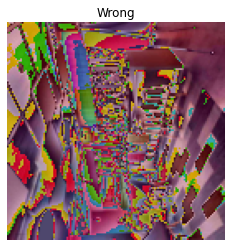

  0%|          | 0/1 [00:00<?, ?it/s]

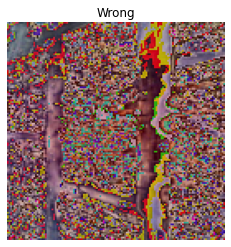

  0%|          | 0/1 [00:00<?, ?it/s]

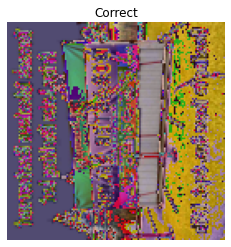

  0%|          | 0/1 [00:00<?, ?it/s]

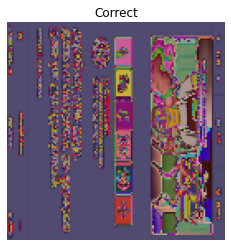

In [73]:
correct, wrong = 0,0

for i in range(20):
    img, text, label = next(iter(test_dl))
    pred = model(img, text).argmax(1)
    title = 'Correct'
    if pred[0] == label[0]:
        correct+=1
        if correct>2: continue
    else:
        wrong+=1
        title = 'Wrong'
        if wrong>2: continue
            
    # Generate the Lime explanation for the example image
    explanation = explainer.explain_instance((img.squeeze().detach().numpy() * 255).astype(np.uint8).transpose(1, 2, 0), predict, top_labels=5, hide_color=0, num_samples=1)

    # Visualize the Lime explanation for the example image
    visualize_explanation((img.squeeze().detach().numpy() * 255).astype(np.uint8).transpose(1, 2, 0), explanation, title = title)
    

## ViLBERT model

In [75]:
class ViLBERT(nn.Module):
    def __init__(self, num_classes, hidden_size, dropout, pretrained = True):
        super(ViLBERT, self).__init__()
        
        # Image model
        efficientnet = efficientnet_b0(pretrained=True)
        efficientnet.classifier[1] = nn.Linear(in_features = 1280, out_features = num_classes, bias = True)
        self.img_model = efficientnet
        
        # Text model
        self.text_model = BertModel.from_pretrained('bert-base-uncased')
        self.text_classifier = nn.Sequential(
            nn.Linear(768, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )
        
        # Combined output model
        self.combined_classifier = nn.Sequential(
            nn.Linear(num_classes*2, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, 5)
        )
        
    def forward(self, img_inputs, text_inputs):
        # Image model forward pass
        img_outputs = self.img_model(img_inputs)
        
        # Text model forward pass
        text_outputs = self.text_model(text_inputs)[0][:, 0, :]
        text_outputs = self.text_classifier(text_outputs)
        
        # Combined output forward pass
        combined_outputs = torch.cat((img_outputs, text_outputs), dim=1)
        combined_outputs = self.combined_classifier(combined_outputs)
        
        return combined_outputs

In [74]:
model = ViLBERT(num_classes=5, hidden_size=256, dropout=0.2, pretrained = True)
#model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(torch.load('saved_models/finetuned.pt'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

  0%|          | 0/1 [00:00<?, ?it/s]

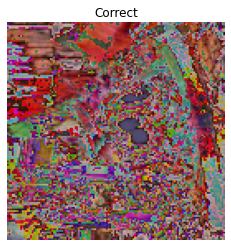

  0%|          | 0/1 [00:00<?, ?it/s]

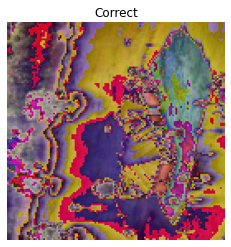

  0%|          | 0/1 [00:00<?, ?it/s]

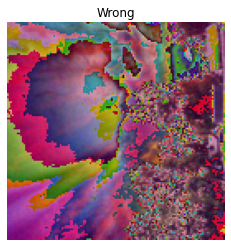

  0%|          | 0/1 [00:00<?, ?it/s]

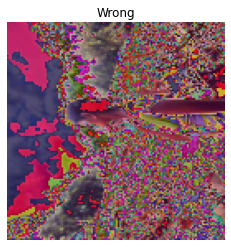

In [76]:
correct, wrong = 0,0

for i in range(20):
    img, text, label = next(iter(test_dl))
    pred = model(img, text).argmax(1)
    title = 'Correct'
    if pred[0] == label[0]:
        correct+=1
        if correct>2: continue
    else:
        wrong+=1
        title = 'Wrong'
        if wrong>2: continue
            
    # Generate the Lime explanation for the example image
    explanation = explainer.explain_instance((img.squeeze().detach().numpy() * 255).astype(np.uint8).transpose(1, 2, 0), predict, top_labels=5, hide_color=0, num_samples=1)

    # Visualize the Lime explanation for the example image
    visualize_explanation((img.squeeze().detach().numpy() * 255).astype(np.uint8).transpose(1, 2, 0), explanation, title = title)
    

# SHAP

In [48]:
img, text, labels = next(iter(train_dl))
print(img.shape, text.shape, labels.shape)
Model = ViLBERT(num_classes=5, hidden_size=256, dropout=0.2, pretrained = True)
Model.load_state_dict(torch.load('saved_models/finetuned.pt'))

torch.Size([32, 3, 132, 132]) torch.Size([32, 45]) torch.Size([32])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [92]:
class Text_model(nn.Module):
    def __init__(self):
        super(Text_model, self).__init__()
        
        self.text_model = Model.text_model
        self.text_classifier = Model.text_classifier
        
    def forward(self, text_inputs):
        tokenized = tokenizer.encode_plus(text_inputs, add_special_tokens=True)
#         print(tokenized)
#         print(torch.tensor(tokenized['input_ids']).shape)
        text_outputs = self.text_model(torch.tensor([tokenized['input_ids']]))[0][:, 0, :]
        text_outputs = self.text_classifier(text_outputs)
        
        return text_outputs
model = Text_model()

In [81]:
df =  pd.read_csv(path+'task_humanitarian_text_img_test.tsv',sep = '\t')
df['tweet_text'].head()

0    .@Lendio has a great event tomorrow for both #...
1    Now @ReposadoBar also Carlo surf band at 8pm #...
2    Earthquake in Mexico rocks PH Embassy, no Fili...
3    Guaynabo resident Efrain Diaz stands by a brid...
4    After Harvey, Irma Leaves Its Own Trail of Des...
Name: tweet_text, dtype: object

In [93]:
model(df.iloc[0]['tweet_text']).shape

torch.Size([1, 5])

In [107]:
shap_values = shap_

(124, None, 2)

In [108]:
shap.plots.text(shap_values)